In [ ]:
# імпорти, корінь проєкту, DEVICE

import os, sys
import time

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath("..")
os.chdir(PROJECT_ROOT)
print("CWD:", os.getcwd())

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from config import DEVICE
from utils.dataset import get_dataloaders
from utils.train_utils import train_with_early_stopping
from models.transfer_models import get_efficientnet_b0

print("Using device:", DEVICE)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


CWD: c:\University\4course\CV_Project
Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Ti


In [ ]:
# helper-функції

def build_efficient_b0_ft(num_classes: int):
    # fine-tuning: feature_extract=False
    model = get_efficientnet_b0(num_classes=num_classes, feature_extract=False)
    return model


def make_optimizer(model, lr_backbone, lr_head, weight_decay):
    backbone_params, head_params = [], []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        if "classifier" in name:
            head_params.append(param)
        else:
            backbone_params.append(param)

    optimizer = optim.AdamW(
        [
            {"params": backbone_params, "lr": lr_backbone},
            {"params": head_params, "lr": lr_head},
        ],
        weight_decay=weight_decay,
    )
    return optimizer


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
# беремо val_loader, щоб дізнатись num_classes

_, val_loader_tmp, class_names = get_dataloaders(aug_type="baseline")
num_classes = len(class_names)
print("Classes:", class_names)


Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
# конфігурації augmentation + regularization

experiments = [
    {
        "name": "baseline_no_reg",
        "aug_type": "baseline",
        "weight_decay": 0.0,
        "label_smoothing": 0.0,
    },
    {
        "name": "baseline_l2",
        "aug_type": "baseline",
        "weight_decay": 1e-4,
        "label_smoothing": 0.0,
    },
    {
        "name": "advanced_l2",
        "aug_type": "advanced",
        "weight_decay": 1e-4,
        "label_smoothing": 0.0,
    },
    {
        "name": "advanced_l2_ls",
        "aug_type": "advanced",
        "weight_decay": 1e-4,
        "label_smoothing": 0.1,
    },
]

experiments


[{'name': 'baseline_no_reg',
  'aug_type': 'baseline',
  'weight_decay': 0.0,
  'label_smoothing': 0.0},
 {'name': 'baseline_l2',
  'aug_type': 'baseline',
  'weight_decay': 0.0001,
  'label_smoothing': 0.0},
 {'name': 'advanced_l2',
  'aug_type': 'advanced',
  'weight_decay': 0.0001,
  'label_smoothing': 0.0},
 {'name': 'advanced_l2_ls',
  'aug_type': 'advanced',
  'weight_decay': 0.0001,
  'label_smoothing': 0.1}]

In [ ]:
# прогін усіх експериментів

os.makedirs("checkpoints", exist_ok=True)
os.makedirs("results/curves", exist_ok=True)

results = []

for exp in experiments:
    print("\n" + "=" * 80)
    print(f"Experiment: {exp['name']}")
    print("=" * 80)

    # 1) DataLoader-и з потрібним aug_type
    train_loader, val_loader, class_names = get_dataloaders(
        aug_type=exp["aug_type"]
    )

    # 2) Модель
    model = build_efficient_b0_ft(num_classes).to(DEVICE)

    # 3) Критерій з label smoothing
    criterion = nn.CrossEntropyLoss(
        label_smoothing=exp["label_smoothing"]
    ).to(DEVICE)

    # 4) Оптимізатор з потрібним weight decay
    optimizer = make_optimizer(
        model,
        lr_backbone=1e-5,
        lr_head=5e-4,
        weight_decay=exp["weight_decay"],
    )

    # 5) Навчання
    ckpt_path = f"checkpoints/efficient_b0_ft_{exp['name']}.pth"
    start_time = time.time()

    model, history, best_val_acc = train_with_early_stopping(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        DEVICE,
        num_epochs=15,
        patience=4,
        checkpoint_path=ckpt_path,
    )
    total_time_min = (time.time() - start_time) / 60.0
    n_params = count_parameters(model)

    print(f"Best val acc ({exp['name']}): {best_val_acc:.4f}")
    print(f"Params: {n_params}, time: {total_time_min:.2f} min")

    # 6) Зберігаємо curves для кожного експерименту
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Loss – {exp['name']}")
    plt.tight_layout()
    plt.savefig(f"results/curves/efficient_b0_ft_{exp['name']}_loss.png")
    plt.close()

    plt.figure()
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"Accuracy – {exp['name']}")
    plt.tight_layout()
    plt.savefig(f"results/curves/efficient_b0_ft_{exp['name']}_acc.png")
    plt.close()

    results.append(
        {
            "config": exp["name"],
            "aug_type": exp["aug_type"],
            "weight_decay": exp["weight_decay"],
            "label_smoothing": exp["label_smoothing"],
            "val_acc": best_val_acc,
            "params": n_params,
            "train_time_min": total_time_min,
            "ckpt_path": ckpt_path,
        }
    )

len(results)



Experiment: baseline_no_reg

Epoch 1/15


Train loss: 0.7131, acc: 0.7959 | Val loss: 0.3547, acc: 0.8850 | Epoch time: 41.0s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_no_reg.pth

Epoch 2/15


Train loss: 0.3333, acc: 0.8871 | Val loss: 0.2760, acc: 0.9053 | Epoch time: 41.6s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_no_reg.pth

Epoch 3/15


Train loss: 0.2636, acc: 0.9103 | Val loss: 0.2510, acc: 0.9137 | Epoch time: 41.3s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_no_reg.pth

Epoch 4/15


Train loss: 0.2324, acc: 0.9186 | Val loss: 0.2345, acc: 0.9183 | Epoch time: 40.9s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_no_reg.pth

Epoch 5/15


Train loss: 0.2082, acc: 0.9270 | Val loss: 0.2235, acc: 0.9153 | Epoch time: 41.7s
No improvement for 1 epoch(s).

Epoch 6/15


Train loss: 0.1884, acc: 0.9347 | Val loss: 0.2176, acc: 0.9167 | Epoch time: 42.0s
No improvement for 2 epoch(s).

Epoch 7/15


Train loss: 0.1764, acc: 0.9377 | Val loss: 0.2099, acc: 0.9207 | Epoch time: 41.3s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_no_reg.pth

Epoch 8/15


Train loss: 0.1599, acc: 0.9457 | Val loss: 0.2076, acc: 0.9230 | Epoch time: 40.5s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_no_reg.pth

Epoch 9/15


Train loss: 0.1457, acc: 0.9465 | Val loss: 0.2060, acc: 0.9220 | Epoch time: 40.6s
No improvement for 1 epoch(s).

Epoch 10/15


Train loss: 0.1339, acc: 0.9520 | Val loss: 0.2091, acc: 0.9243 | Epoch time: 41.3s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_no_reg.pth

Epoch 11/15


Train loss: 0.1277, acc: 0.9540 | Val loss: 0.2058, acc: 0.9260 | Epoch time: 40.7s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_no_reg.pth

Epoch 12/15


Train loss: 0.1182, acc: 0.9577 | Val loss: 0.2052, acc: 0.9263 | Epoch time: 40.7s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_no_reg.pth

Epoch 13/15


Train loss: 0.1094, acc: 0.9600 | Val loss: 0.2108, acc: 0.9240 | Epoch time: 40.6s
No improvement for 1 epoch(s).

Epoch 14/15


Train loss: 0.0981, acc: 0.9658 | Val loss: 0.2063, acc: 0.9287 | Epoch time: 40.7s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_no_reg.pth

Epoch 15/15


Train loss: 0.0944, acc: 0.9668 | Val loss: 0.2087, acc: 0.9263 | Epoch time: 41.2s
No improvement for 1 epoch(s).
Best val acc (baseline_no_reg): 0.9287
Params: 4015234, time: 10.28 min

Experiment: baseline_l2

Epoch 1/15


Train loss: 0.7210, acc: 0.7871 | Val loss: 0.3542, acc: 0.8820 | Epoch time: 41.5s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_l2.pth

Epoch 2/15


Train loss: 0.3302, acc: 0.8886 | Val loss: 0.2737, acc: 0.9073 | Epoch time: 41.2s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_l2.pth

Epoch 3/15


Train loss: 0.2695, acc: 0.9079 | Val loss: 0.2483, acc: 0.9113 | Epoch time: 40.9s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_l2.pth

Epoch 4/15


Train loss: 0.2301, acc: 0.9193 | Val loss: 0.2338, acc: 0.9157 | Epoch time: 40.9s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_l2.pth

Epoch 5/15


Train loss: 0.2134, acc: 0.9249 | Val loss: 0.2207, acc: 0.9180 | Epoch time: 41.4s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_l2.pth

Epoch 6/15


Train loss: 0.1934, acc: 0.9336 | Val loss: 0.2167, acc: 0.9203 | Epoch time: 40.2s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_l2.pth

Epoch 7/15


Train loss: 0.1724, acc: 0.9393 | Val loss: 0.2136, acc: 0.9223 | Epoch time: 42.4s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_l2.pth

Epoch 8/15


Train loss: 0.1634, acc: 0.9423 | Val loss: 0.2086, acc: 0.9223 | Epoch time: 41.0s
No improvement for 1 epoch(s).

Epoch 9/15


Train loss: 0.1480, acc: 0.9471 | Val loss: 0.2097, acc: 0.9230 | Epoch time: 40.6s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_l2.pth

Epoch 10/15


Train loss: 0.1388, acc: 0.9522 | Val loss: 0.2026, acc: 0.9243 | Epoch time: 40.9s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_l2.pth

Epoch 11/15


Train loss: 0.1214, acc: 0.9562 | Val loss: 0.2058, acc: 0.9240 | Epoch time: 42.5s
No improvement for 1 epoch(s).

Epoch 12/15


Train loss: 0.1175, acc: 0.9562 | Val loss: 0.2068, acc: 0.9257 | Epoch time: 41.2s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_l2.pth

Epoch 13/15


Train loss: 0.1108, acc: 0.9615 | Val loss: 0.2113, acc: 0.9263 | Epoch time: 41.1s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_l2.pth

Epoch 14/15


Train loss: 0.0965, acc: 0.9661 | Val loss: 0.2030, acc: 0.9310 | Epoch time: 41.1s
==> New best model saved to checkpoints/efficient_b0_ft_baseline_l2.pth

Epoch 15/15


Train loss: 0.0950, acc: 0.9663 | Val loss: 0.2062, acc: 0.9273 | Epoch time: 41.4s
No improvement for 1 epoch(s).
Best val acc (baseline_l2): 0.9310
Params: 4015234, time: 10.31 min

Experiment: advanced_l2

Epoch 1/15


Train loss: 0.9261, acc: 0.6915 | Val loss: 0.5184, acc: 0.8430 | Epoch time: 41.3s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2.pth

Epoch 2/15


Train loss: 0.5308, acc: 0.8075 | Val loss: 0.3814, acc: 0.8750 | Epoch time: 41.0s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2.pth

Epoch 3/15


Train loss: 0.4583, acc: 0.8338 | Val loss: 0.3399, acc: 0.8840 | Epoch time: 41.0s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2.pth

Epoch 4/15


Train loss: 0.4143, acc: 0.8503 | Val loss: 0.3059, acc: 0.8920 | Epoch time: 41.8s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2.pth

Epoch 5/15


Train loss: 0.3933, acc: 0.8590 | Val loss: 0.2815, acc: 0.9007 | Epoch time: 41.8s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2.pth

Epoch 6/15


Train loss: 0.3737, acc: 0.8628 | Val loss: 0.2701, acc: 0.9023 | Epoch time: 41.5s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2.pth

Epoch 7/15


Train loss: 0.3574, acc: 0.8702 | Val loss: 0.2566, acc: 0.9103 | Epoch time: 41.1s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2.pth

Epoch 8/15


Train loss: 0.3413, acc: 0.8767 | Val loss: 0.2509, acc: 0.9133 | Epoch time: 41.1s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2.pth

Epoch 9/15


Train loss: 0.3273, acc: 0.8814 | Val loss: 0.2419, acc: 0.9190 | Epoch time: 41.2s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2.pth

Epoch 10/15


Train loss: 0.3154, acc: 0.8876 | Val loss: 0.2326, acc: 0.9207 | Epoch time: 41.2s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2.pth

Epoch 11/15


Train loss: 0.3079, acc: 0.8910 | Val loss: 0.2314, acc: 0.9173 | Epoch time: 41.8s
No improvement for 1 epoch(s).

Epoch 12/15


Train loss: 0.3104, acc: 0.8874 | Val loss: 0.2264, acc: 0.9220 | Epoch time: 41.5s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2.pth

Epoch 13/15


Train loss: 0.2876, acc: 0.8950 | Val loss: 0.2229, acc: 0.9187 | Epoch time: 42.0s
No improvement for 1 epoch(s).

Epoch 14/15


Train loss: 0.2827, acc: 0.8953 | Val loss: 0.2202, acc: 0.9167 | Epoch time: 42.0s
No improvement for 2 epoch(s).

Epoch 15/15


Train loss: 0.2842, acc: 0.8973 | Val loss: 0.2176, acc: 0.9190 | Epoch time: 42.5s
No improvement for 3 epoch(s).
Best val acc (advanced_l2): 0.9220
Params: 4015234, time: 10.38 min

Experiment: advanced_l2_ls

Epoch 1/15


Train loss: 1.1040, acc: 0.6944 | Val loss: 0.8169, acc: 0.8363 | Epoch time: 42.6s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2_ls.pth

Epoch 2/15


Train loss: 0.8539, acc: 0.8053 | Val loss: 0.7514, acc: 0.8663 | Epoch time: 41.8s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2_ls.pth

Epoch 3/15


Train loss: 0.7987, acc: 0.8335 | Val loss: 0.7210, acc: 0.8777 | Epoch time: 40.7s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2_ls.pth

Epoch 4/15


Train loss: 0.7760, acc: 0.8450 | Val loss: 0.6911, acc: 0.8923 | Epoch time: 41.8s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2_ls.pth

Epoch 5/15


Train loss: 0.7521, acc: 0.8566 | Val loss: 0.6742, acc: 0.8997 | Epoch time: 41.7s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2_ls.pth

Epoch 6/15


Train loss: 0.7371, acc: 0.8611 | Val loss: 0.6617, acc: 0.9020 | Epoch time: 40.9s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2_ls.pth

Epoch 7/15


Train loss: 0.7222, acc: 0.8748 | Val loss: 0.6520, acc: 0.9067 | Epoch time: 40.9s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2_ls.pth

Epoch 8/15


Train loss: 0.7176, acc: 0.8712 | Val loss: 0.6442, acc: 0.9093 | Epoch time: 41.2s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2_ls.pth

Epoch 9/15


Train loss: 0.6973, acc: 0.8814 | Val loss: 0.6378, acc: 0.9130 | Epoch time: 41.3s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2_ls.pth

Epoch 10/15


Train loss: 0.6931, acc: 0.8823 | Val loss: 0.6306, acc: 0.9103 | Epoch time: 40.9s
No improvement for 1 epoch(s).

Epoch 11/15


Train loss: 0.6801, acc: 0.8899 | Val loss: 0.6221, acc: 0.9150 | Epoch time: 41.0s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2_ls.pth

Epoch 12/15


Train loss: 0.6797, acc: 0.8873 | Val loss: 0.6195, acc: 0.9187 | Epoch time: 41.6s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2_ls.pth

Epoch 13/15


Train loss: 0.6737, acc: 0.8903 | Val loss: 0.6143, acc: 0.9193 | Epoch time: 41.8s
==> New best model saved to checkpoints/efficient_b0_ft_advanced_l2_ls.pth

Epoch 14/15


Train loss: 0.6623, acc: 0.8991 | Val loss: 0.6171, acc: 0.9183 | Epoch time: 42.8s
No improvement for 1 epoch(s).

Epoch 15/15


Train loss: 0.6596, acc: 0.8999 | Val loss: 0.6086, acc: 0.9190 | Epoch time: 41.0s
No improvement for 2 epoch(s).
Best val acc (advanced_l2_ls): 0.9193
Params: 4015234, time: 10.37 min


4

In [ ]:
# summary table

df = pd.DataFrame(results)
df


,config,aug_type,weight_decay,label_smoothing,val_acc,params,train_time_min,ckpt_path
0,baseline_no_reg,baseline,0.0000,0.0,0.928667,4015234,10.276026,checkpoints/efficient_b0_ft_baseline_no_reg.pth
1,baseline_l2,baseline,0.0001,0.0,0.931000,4015234,10.314731,checkpoints/efficient_b0_ft_baseline_l2.pth
2,advanced_l2,advanced,0.0001,0.0,0.922000,4015234,10.382791,checkpoints/efficient_b0_ft_advanced_l2.pth
3,advanced_l2_ls,advanced,0.0001,0.1,0.919333,4015234,10.373678,checkpoints/efficient_b0_ft_advanced_l2_ls.pth


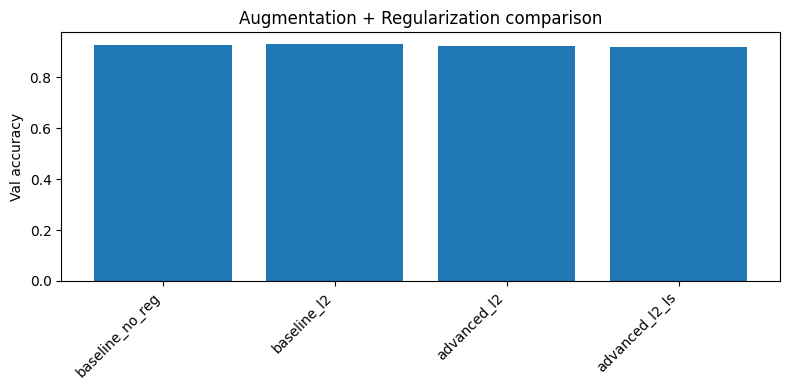

In [ ]:
# barplot val_acc для кожної конфігурації

plt.figure(figsize=(8, 4))
plt.bar(df["config"], df["val_acc"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Val accuracy")
plt.title("Augmentation + Regularization comparison")
plt.tight_layout()
plt.show()


In [ ]:
# ensemble двох найкращих конфігів

from sklearn.metrics import accuracy_score

# обираємо два топові конфіги за val_acc
df_sorted = df.sort_values(by="val_acc", ascending=False)
top2 = df_sorted.head(2)
top2


,config,aug_type,weight_decay,label_smoothing,val_acc,params,train_time_min,ckpt_path
1,baseline_l2,baseline,0.0001,0.0,0.931000,4015234,10.314731,checkpoints/efficient_b0_ft_baseline_l2.pth
0,baseline_no_reg,baseline,0.0000,0.0,0.928667,4015234,10.276026,checkpoints/efficient_b0_ft_baseline_no_reg.pth


In [9]:
# завантажимо дві моделі

models_ensemble = []

for _, row in top2.iterrows():
    cfg = row["config"]
    aug_type = row["aug_type"]
    ckpt_path = row["ckpt_path"]

    print(f"Loading model for config {cfg} from {ckpt_path}")

    # тут важливо: для ensemble на val ми можемо взяти val_loader з будь-яким aug_type,
    # краще без сильних аугментацій – наприклад, baseline:
    _, val_loader_eval, _ = get_dataloaders(aug_type="baseline")

    model = build_efficient_b0_ft(num_classes).to(DEVICE)
    state_dict = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(state_dict)
    model.eval()
    models_ensemble.append(model)

# оцінка ансамблю
all_preds_ens, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader_eval:
        images = images.to(DEVICE)

        logits_sum = None
        for m in models_ensemble:
            outputs = m(images)
            if logits_sum is None:
                logits_sum = outputs
            else:
                logits_sum += outputs

        preds = logits_sum.argmax(dim=1).cpu()
        all_preds_ens.extend(preds.tolist())
        all_labels.extend(labels.tolist())

ensemble_acc = accuracy_score(all_labels, all_preds_ens)
ensemble_acc


Loading model for config baseline_l2 from checkpoints/efficient_b0_ft_baseline_l2.pth
Loading model for config baseline_no_reg from checkpoints/efficient_b0_ft_baseline_no_reg.pth


0.9276666666666666